In [29]:
import numpy as np
from scipy.linalg import eigh, eig
from scipy.stats import uniform, bernoulli
import itertools
import matplotlib.pyplot as plt
import networkx as nx

In [38]:
class ErdosRenyiFJ:
    def __init__(self, n, p, w_lower, w_upper, internal_lower, internal_upper, directed=False):
        assert w_lower >= 0
        assert w_upper >= w_lower
        self.n = n
        self.directed = directed
        if directed:
            self.weights = bernoulli.rvs(p, size=[n,n]) * uniform.rvs(loc=w_lower, scale=w_upper - w_lower, size=[n, n])
            # zero out the diagonal since w_{ii} is only used for internal opinions rather than expressed opinions
            for i in range(n):
                self.weights[i][i] = 0
        else:
            upper_triangular_weights = np.triu(uniform.rvs(
                loc=w_lower, scale=w_upper - w_lower, size=[n, n])* bernoulli.rvs(p, size=[n,n]), k=1)
            self.weights = upper_triangular_weights + upper_triangular_weights.T - np.diag(upper_triangular_weights.diagonal())
        self.internal = uniform.rvs(loc=internal_lower, scale=internal_upper - internal_lower, size=n)
        self.expressed = self.internal.copy()

    def __repr__(self):
        return f'weights: \n{self.weights}\ninternal: {self.internal}\nexpressed: {self.expressed}'

    def laplacian(self):
        degree_matrix = np.diag(np.sum(self.weights, axis=1))
        laplacian = degree_matrix - self.weights
        return laplacian

    def disagreement(self):
        disagreement = 0
        for i, j in itertools.product(range(self.n), range(self.n)):
            disagreement += abs(self.weights[i][j]) * (self.expressed[i] - self.expressed[j]) ** 2
        return disagreement

    def polarization(self):
        avg_expressed = np.sum(self.expressed) / self.n
        mean_centered_expressed = self.expressed - avg_expressed
        return np.dot(mean_centered_expressed, mean_centered_expressed)

    def update_weights(self):
        pass

    def run_one_step(self):
        # update_weights have type (self) -> ()
        new_expressed = self.expressed.copy()
        self.expressed = (self.internal + self.weights @ self.expressed) / (1 + np.sum(self.weights, axis=1))
        self.update_weights()
        
    def run_t_steps(self, t):
        for i in range(t):
            self.run_one_step()

    def plot_network(self):
        nodes = list(range(self.n))
        edges = []
        for i in range(self.n):
            for j in range(self.n):
                if self.weights[i][j] >= 0.001:
                    edges.append((i, j, self.weights[i][j]))
        
        # Create a weighted graph
        if self.directed:
            G = nx.DiGraph()
        else:
            G = nx.Graph()
        G.add_nodes_from(nodes)
        G.add_weighted_edges_from(edges)
        
        # Get positions for nodes
        pos = nx.spring_layout(G)  # Spring layout for a visually appealing result
        
        # Draw the graph
        plt.figure(figsize=(8, 6))
        edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
        nx.draw(G, pos, node_color='b', edgelist=edges, edge_color=weights, width=2.0, node_size=10, edge_cmap=plt.cm.Blues)
        # nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{d["weight"]}' for u, v, d in G.edges(data=True)}, font_size=10)
        
        plt.title("Weighted Graph")
        plt.show()

In [25]:
class HalvingFJ(ErdosRenyiFJ):
    def __init__(self, n, p, w_lower, w_upper, internal_lower, internal_upper, theta, discount_factor=1/2, directed=False):
        ''' people whose expressed opinion differ by more than theta have their weights multiplied by the discount factor '''
        super().__init__(n, p, w_lower, w_upper, internal_lower, internal_upper, directed)
        self.theta = theta
        self.discount_factor = discount_factor
    
    def update_weights(self):
        # np.abs(self.expressed.reshape(-1, 1) - self.expressed) > self.theta is 1 if they're very different and 0 if they're close
        self.weights = (1 - (np.abs(self.expressed.reshape(-1, 1) - self.expressed) > self.theta) * (1 - discount_factor)) * self.weights

10.216926214216237
9.633414294523828


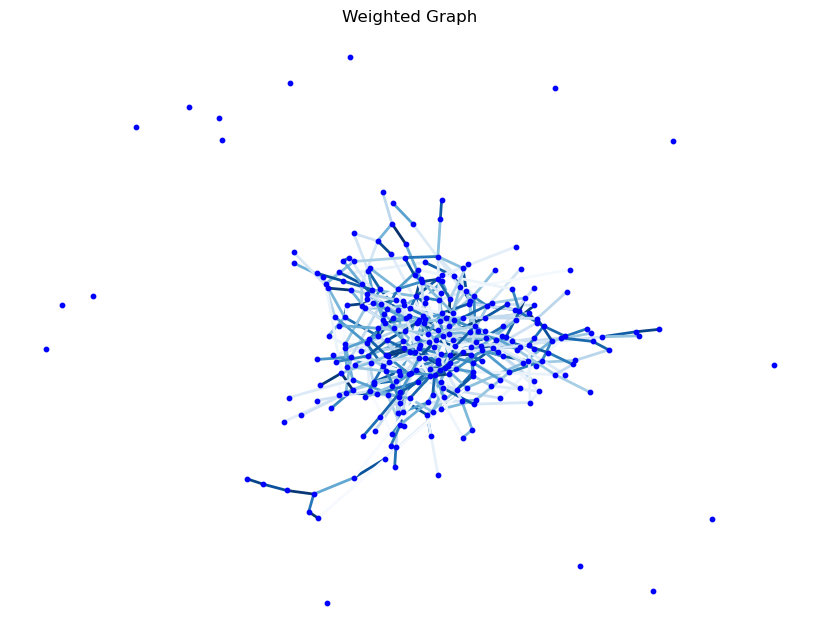

In [42]:
G = ErdosRenyiFJ(300, 0.01, 0, 1, 0, 1)
G.run_t_steps(1000)
# print(G)
print(G.disagreement())
print(G.polarization())
G.plot_network()

In [5]:
G = HalvingFJ(10, 0.5, 0, 1, 0, 1, theta=0.2)
G.run_t_steps(1000)
print(G)

weights: 
[[0.00000000e+000 7.83043777e-001 7.47726319e-303 0.00000000e+000
  0.00000000e+000 4.65863907e-002 2.50832784e-302 9.95509671e-001
  0.00000000e+000 0.00000000e+000]
 [7.83043777e-001 0.00000000e+000 7.52815665e-302 0.00000000e+000
  0.00000000e+000 2.45406826e-001 0.00000000e+000 0.00000000e+000
  1.08560066e-001 0.00000000e+000]
 [7.47726319e-303 7.52815665e-302 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 1.81582530e-301 0.00000000e+000 6.10884153e-302
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 2.27140003e-001 4.82192228e-301 5.47167122e-001
  5.54094195e-001 0.00000000e+000]
 [4.65863907e-002 2.45406826e-001 0.00000000e+000 1.81582530e-301
  2.27140003e-001 0.00000000e+000 2.28809678e-300 0.00000000e+000
  6.35551092e-001 0.000

In [6]:
def get_disagreement_polarization_eigenvalues(model, num_steps=1000, num_trials=100):
    disagreements = []
    polarizations = []
    eigenvalues = []
    for trial in range(num_trials):
        G = model()
        G.run_t_steps(num_steps)
        disagreements.append(G.disagreement())
        polarizations.append(G.polarization())
        eigenvalues.append(eigh(G.laplacian(), eigvals_only=True))
    return np.sum(disagreements) / num_trials, np.sum(polarizations) / num_trials, np.sum(eigenvalues, axis=0) / num_trials

### Basic FJ model on $G_{n,p}$ for $p=\frac12$ where all weights are $w_{ij}$ uniform $[0,1]$ i.i.d., internal opinions are uniform $[0,1]$ i.i.d.

In [8]:
model = lambda: ErdosRenyiFJ(n=300, p=1/2, w_lower=0, w_upper=1, internal_lower=0, internal_upper=1)
get_disagreement_polarization_eigenvalues(model, num_steps=1000, num_trials=10)

(0.643940478724861,
 0.004398140831801552,
 array([1.27897692e-14, 5.71643680e+01, 5.85400463e+01, 5.92221116e+01,
        5.97534933e+01, 5.99985701e+01, 6.03333641e+01, 6.05849225e+01,
        6.09325677e+01, 6.11215135e+01, 6.13430607e+01, 6.16017279e+01,
        6.18380261e+01, 6.19785607e+01, 6.21681612e+01, 6.23062488e+01,
        6.24711590e+01, 6.26438884e+01, 6.27885904e+01, 6.29403368e+01,
        6.31037219e+01, 6.32268663e+01, 6.33738055e+01, 6.34997027e+01,
        6.36754747e+01, 6.37758485e+01, 6.39096897e+01, 6.40435065e+01,
        6.41376765e+01, 6.42689827e+01, 6.43700200e+01, 6.44893116e+01,
        6.46389463e+01, 6.47212393e+01, 6.48263212e+01, 6.49498211e+01,
        6.50494554e+01, 6.51536551e+01, 6.52573192e+01, 6.53897991e+01,
        6.54696511e+01, 6.55906528e+01, 6.56776135e+01, 6.57661171e+01,
        6.58896064e+01, 6.59692598e+01, 6.60853772e+01, 6.61552403e+01,
        6.62721439e+01, 6.63745959e+01, 6.64933850e+01, 6.65699361e+01,
        6.66747148e+0

### Basic FJ model on $G_{n,p}$ for $p=\frac{1}{n}$ where all weights are $w_{ij}$ uniform $[0,1]$ i.i.d., internal opinions are uniform $[0,1]$ i.i.d.

In [11]:
model = lambda: ErdosRenyiFJ(n=300, p=1/300, w_lower=0, w_upper=1, internal_lower=0, internal_upper=1)
get_disagreement_polarization_eigenvalues(model, num_steps=1000, num_trials=10)

(4.524546022520718,
 17.226252714544835,
 array([-1.10242275e-15, -1.02022125e-15, -8.94927801e-16, -7.98739989e-16,
        -7.31274197e-16, -6.80638996e-16, -6.37497630e-16, -5.79570486e-16,
        -5.47576073e-16, -5.27953351e-16, -5.04030845e-16, -4.81996086e-16,
        -4.64617115e-16, -4.42131035e-16, -4.18510005e-16, -4.03863336e-16,
        -3.74364461e-16, -3.59662836e-16, -3.36350271e-16, -3.18019055e-16,
        -3.01540249e-16, -2.87342285e-16, -2.78412622e-16, -2.65783254e-16,
        -2.54029187e-16, -2.41917314e-16, -2.27781292e-16, -2.10440135e-16,
        -2.03046732e-16, -1.92388715e-16, -1.79362116e-16, -1.72175665e-16,
        -1.64900234e-16, -1.52850862e-16, -1.44661843e-16, -1.33951067e-16,
        -1.26475450e-16, -1.19556652e-16, -1.13278596e-16, -1.05511373e-16,
        -9.74494165e-17, -9.10713336e-17, -8.73575495e-17, -7.80866587e-17,
        -7.21927990e-17, -6.59000850e-17, -6.17342055e-17, -5.66451931e-17,
        -5.23052567e-17, -4.83576399e-17, -4.42

## Weight Halving Threshold Model with uniform threshold $\theta_{ij} = \theta$

In [23]:
average_disagreements = []
average_polarizations = []
average_eigenvalues = []
thetas = np.linspace(0,1,num=20)
for theta in thetas:
    model = lambda: HalvingFJ(n=300, p=1/20, w_lower=0, w_upper=1, internal_lower=0, internal_upper=1, theta=theta)
    average_disagreement, average_polarization, average_eigenvalue = get_disagreement_polarization_eigenvalues(model, num_steps=1000, num_trials=10)
    average_disagreements.append(average_disagreement)
    average_polarizations.append(average_polarization)
    average_eigenvalues.append(average_eigenvalue)

print(average_disagreements)
print(average_polarizations)

[3.4391049228745343e-299, 0.17230056304481486, 1.650236190734709, 6.244578279982295, 5.888706449350961, 5.663733841363715, 5.788046669075027, 5.800979853594348, 5.639039231989909, 5.746289236150517, 5.804315657671388, 5.736598787444316, 5.636481095893677, 5.9171816471671335, 5.787818685090936, 5.698013656251253, 5.770201544293489, 5.8201483259686615, 5.597320372599491, 5.779082177673799]
[23.99782085642021, 24.473914713358248, 22.339393600917624, 1.496202895067669, 0.6577136007454635, 0.5386585636839278, 0.5467994506731897, 0.5478304410417343, 0.530847438491281, 0.519186760846846, 0.5499188902013846, 0.5362543701786125, 0.5282868639618872, 0.5581675290530902, 0.5455316754886301, 0.5385604513223758, 0.525468806504099, 0.5500140466904061, 0.514253284565241, 0.529000256885741]


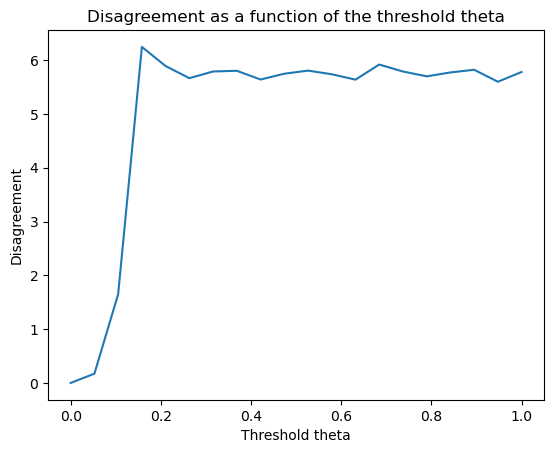

In [26]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Disagreement')
ax.set_title('Disagreement as a function of the threshold theta')
ax.plot(thetas, average_disagreements)
fig.savefig('threshold_model_halve_weight_disagreement.png')

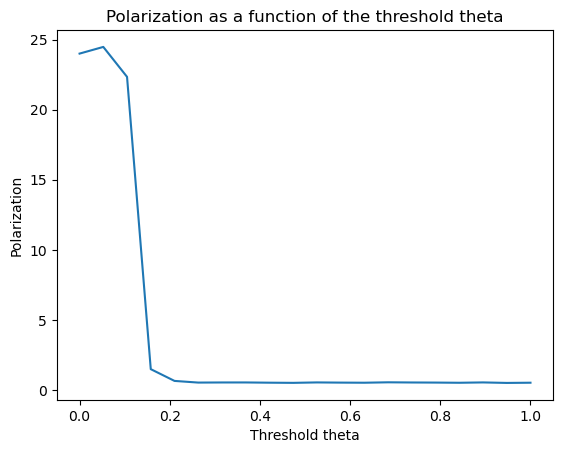

In [27]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Polarization')
ax.set_title('Polarization as a function of the threshold theta')
ax.plot(thetas, average_polarizations)
fig.savefig('threshold_model_halve_weight_polarization.png')

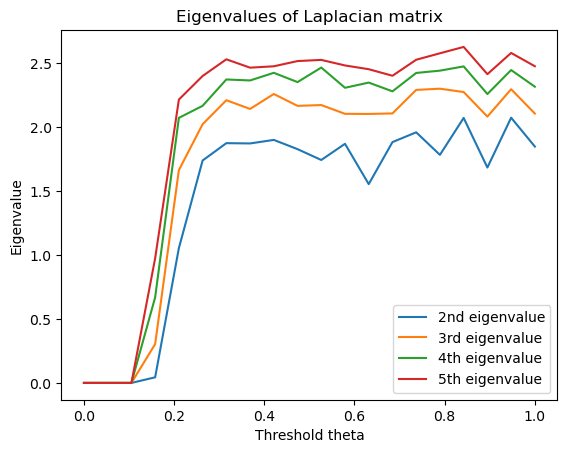

In [28]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Eigenvalue')
ax.set_title('Eigenvalues of Laplacian matrix')
ax.plot(thetas, np.array(average_eigenvalues)[:,1], label='2nd eigenvalue')
ax.plot(thetas, np.array(average_eigenvalues)[:,2], label='3rd eigenvalue')
ax.plot(thetas, np.array(average_eigenvalues)[:,3], label='4th eigenvalue')
ax.plot(thetas, np.array(average_eigenvalues)[:,4], label='5th eigenvalue')
ax.legend()
fig.savefig('threshold_model_halve_weight_polarization.png')

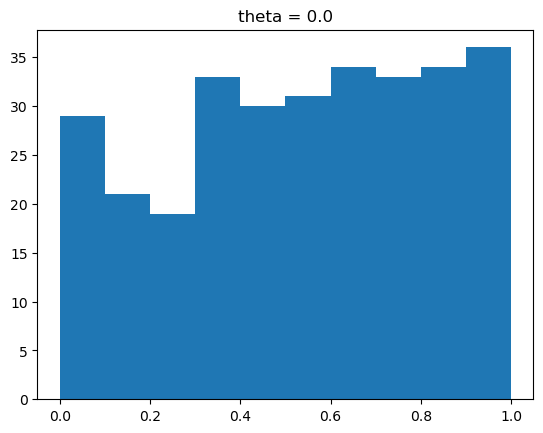

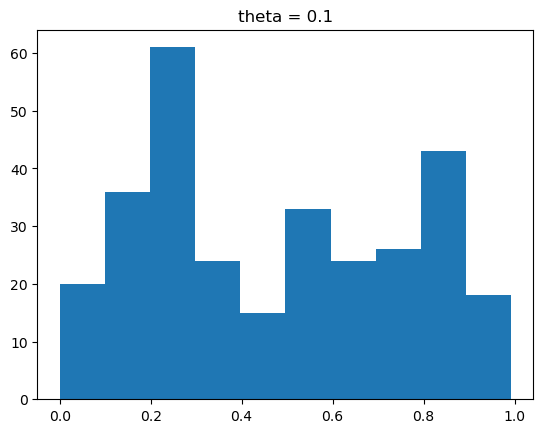

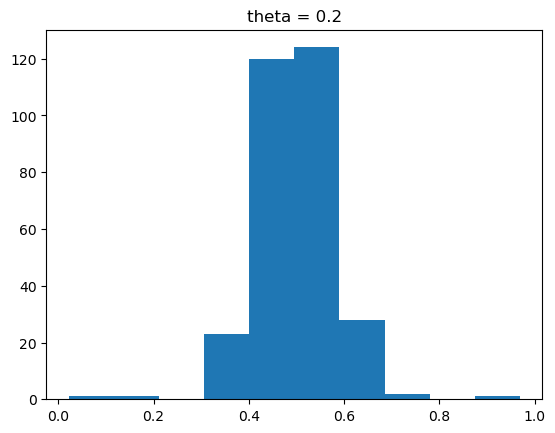

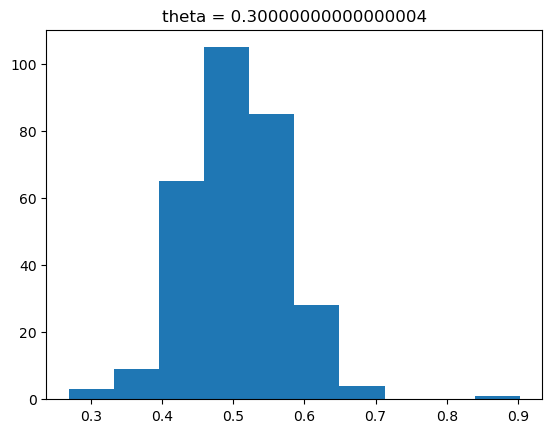

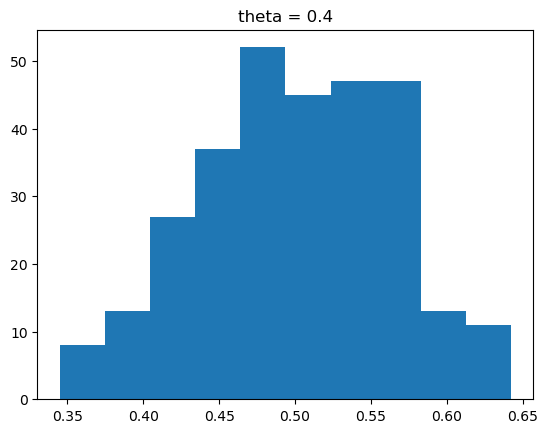

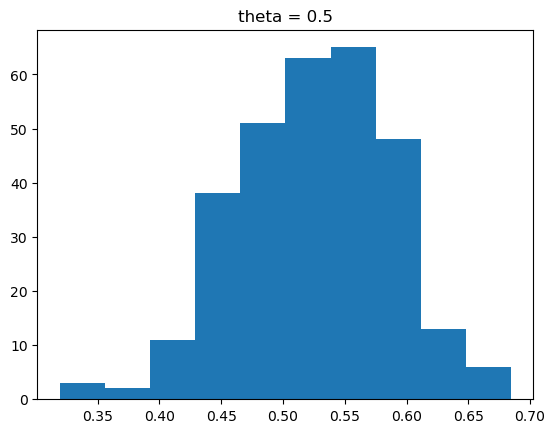

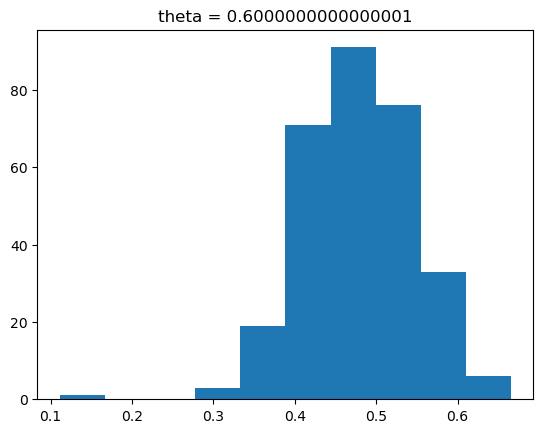

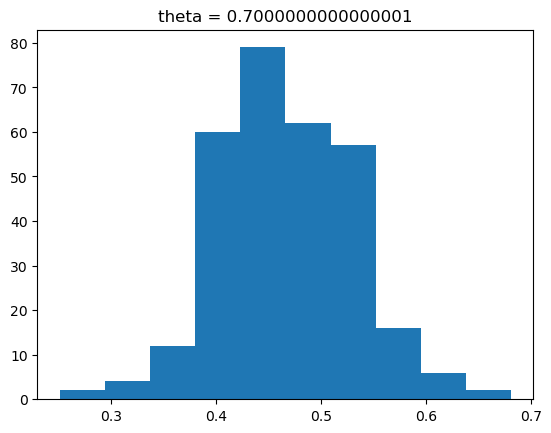

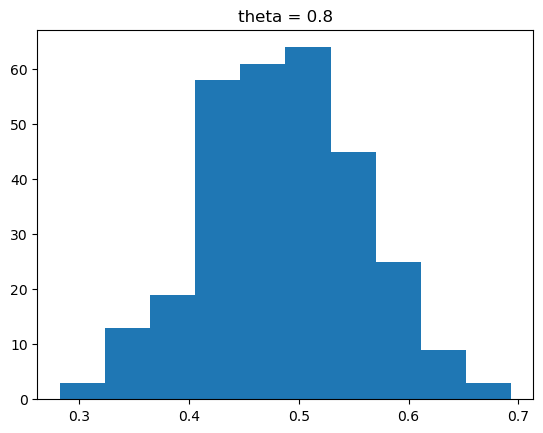

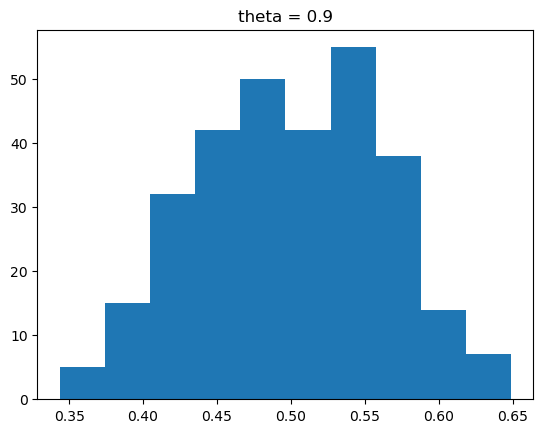

In [17]:
for theta in np.arange(0, 1, 0.1):
    G = HalvingFJ(n=300, p=1/30, w_lower=0, w_upper=1, internal_lower=0, internal_upper=1, theta=theta)
    G.run_t_steps(1000)
    plt.hist(G.expressed)
    plt.title(f'theta = {theta}')
    plt.show()

# Trash (To be cleaned)

### Negative weight FJ model on $G_{n,p}$ for $p=\frac12$ where all weights are $w_{ij}$ uniform $[-1,1]$ i.i.d., internal opinions are uniform $[0,1]$ i.i.d. Using sigmoid function to normalize

In [ ]:
from scipy.special import expit

In [ ]:
def run_fj_and_return_expressed_opinions():
    n = 300
    p = 1/2
    G = nx.erdos_renyi_graph(n, p)
    for edge in G.edges:
        G.edges[edge]['weight'] = uniform.rvs(loc=-1, scale=2)
    
    internal_opinions = uniform.rvs(size=n)
    expressed_opinions = internal_opinions.copy()
    T = 1000
    for t in range(T):
        new_expressed_opinions = expressed_opinions.copy()
        for i, nbrs in G.adj.items():
            sum_neighboring_expressed_opinion = sum(expressed_opinions[j] * eattr['weight'] for j, eattr in nbrs.items())
            sum_neighboring_weight = sum(eattr['weight'] for j, eattr in nbrs.items())
            new_expressed_opinions[i] = expit(internal_opinions[i] + sum_neighboring_expressed_opinion)
        expressed_opinions = new_expressed_opinions.copy()
    return G, expressed_opinions

num_trials = 10
disagreements = []
polarizations = []
for trial in range(num_trials):
    G, opinions = run_fj_and_return_expressed_opinions()
    disagreements.append(disagreement(G, opinions))
    polarizations.append(polarization(G, opinions))

In [ ]:
np.sum(disagreements) / num_trials, np.sum(polarizations) / num_trials

### Same setup, but with weight halving threshold model with uniform threshold $\theta_{ij} = \theta$

In [ ]:
import networkx as nx
def run_fj_and_return_expressed_opinions(theta):
    # n = 300
    n = 10
    p = 1/2
    G = nx.erdos_renyi_graph(n, p)
    for edge in G.edges:
        G.edges[edge]['weight'] = uniform.rvs()
    
    internal_opinions = uniform.rvs(size=n)
    expressed_opinions = internal_opinions.copy()

    def update_weights():
        for i, nbrs in G.adj.items():
            for j, eattr in nbrs.items():
                if abs(expressed_opinions[i] - expressed_opinions[j]) >= theta:
                    eattr['weight'] /= 2
    T = 1000
    # T = 2
    for t in range(T):

        # print('-' * 50)
        # print('Before update weights:')
        # for i, nbrs in G.adj.items():
        #     for j, eattr in nbrs.items():
        #         print(i, j, round(eattr['weight'], 5), end=';\t')
        #     print()
            
        update_weights()
        # print('After update weights:')
        # for i, nbrs in G.adj.items():
        #     for j, eattr in nbrs.items():
        #         print(i, j, round(eattr['weight'], 5), end=';\t')
        #     print()

        new_expressed_opinions = expressed_opinions.copy()
        for i, nbrs in G.adj.items():
            sum_neighboring_expressed_opinion = sum(expressed_opinions[j] * eattr['weight'] for j, eattr in nbrs.items())
            sum_neighboring_weight = sum(eattr['weight'] for j, eattr in nbrs.items())
            new_expressed_opinions[i] = (internal_opinions[i] + sum_neighboring_expressed_opinion) / (1 + sum_neighboring_weight)
        expressed_opinions = new_expressed_opinions.copy()
    return G, expressed_opinions

def find_disagreement_and_polarization_given_theta(theta):
    num_trials = 3
    disagreements = []
    polarizations = []
    for trial in range(num_trials):
        G, opinions = run_fj_and_return_expressed_opinions(theta)
        disagreements.append(disagreement(G, opinions))
        polarizations.append(polarization(G, opinions))
    return np.sum(disagreements) / num_trials, np.sum(polarizations) / num_trials

G, expressed_opinions = run_fj_and_return_expressed_opinions(theta=0.01)
for i, nbrs in G.adj.items():
    for j, eattr in nbrs.items():
        print(i, j, round(eattr['weight'], 5), end=';\t')
    print()

# average_disagreements = []
# average_polarizations = []
# thetas = np.linspace(0,1,num=10)
# for theta in thetas:
#     average_disagreement, average_polarization = find_disagreement_and_polarization_given_theta(theta)
#     average_disagreements.append(average_disagreement)
#     average_polarizations.append(average_polarization)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Disagreement')
ax.set_title('Disagreement as a function of the threshold theta')
ax.plot(thetas, average_disagreements)
fig.savefig('threshold_model_halve_weight_disagreement.png')

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Polarization')
ax.set_title('Polarization as a function of the threshold theta')
ax.plot(thetas, average_polarizations)
fig.savefig('threshold_model_halve_weight_polarization.png')

### Same thing, but weight increasing by $\delta = 1/10$

In [ ]:
def run_fj_and_return_expressed_opinions(theta):
    n = 300
    p = 1/2
    G = nx.erdos_renyi_graph(n, p)
    for edge in G.edges:
        G.edges[edge]['weight'] = uniform.rvs()
    
    internal_opinions = uniform.rvs(size=n)
    expressed_opinions = internal_opinions.copy()

    delta = 1/10
    def update_weights():
        for i, nbrs in G.adj.items():
            for j, eattr in nbrs.items():
                if abs(expressed_opinions[i] - expressed_opinions[j]) >= theta:
                    eattr['weight'] = min(eattr['weight'] + delta, 1) 
    T = 1000
    for t in range(T):

        update_weights()

        new_expressed_opinions = expressed_opinions.copy()
        for i, nbrs in G.adj.items():
            sum_neighboring_expressed_opinion = sum(expressed_opinions[j] * eattr['weight'] for j, eattr in nbrs.items())
            sum_neighboring_weight = sum(eattr['weight'] for j, eattr in nbrs.items())
            new_expressed_opinions[i] = (internal_opinions[i] + sum_neighboring_expressed_opinion) / (1 + sum_neighboring_weight)
        expressed_opinions = new_expressed_opinions.copy()
    return G, expressed_opinions

def find_disagreement_and_polarization_given_theta(theta):
    num_trials = 3
    disagreements = []
    polarizations = []
    for trial in range(num_trials):
        G, opinions = run_fj_and_return_expressed_opinions(theta)
        disagreements.append(disagreement(G, opinions))
        polarizations.append(polarization(G, opinions))
    return np.sum(disagreements) / num_trials, np.sum(polarizations) / num_trials

average_disagreements = []
average_polarizations = []
thetas = np.linspace(0,1,num=10)
for theta in thetas:
    average_disagreement, average_polarization = find_disagreement_and_polarization_given_theta(theta)
    average_disagreements.append(average_disagreement)
    average_polarizations.append(average_polarization)

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Disagreement')
ax.set_title('Disagreement as a function of the threshold theta')
ax.plot(thetas, average_disagreements)
fig.savefig('threshold_model_increase_weight_disagreement.png')

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Polarization')
ax.set_title('Polarization as a function of the threshold theta')
ax.plot(thetas, average_polarizations)
fig.savefig('threshold_model_increase_weight_polarization.png')

### Same thing but using the probabilistic model

In [ ]:
from scipy.stats import bernoulli

In [ ]:
def run_fj_and_return_expressed_opinions(delta):
    n = 300
    p = 1/2
    G = nx.erdos_renyi_graph(n, p)
    for edge in G.edges:
        G.edges[edge]['weight'] = uniform.rvs()
    
    internal_opinions = uniform.rvs(size=n)
    expressed_opinions = internal_opinions.copy()

    def update_weights():
        for i, nbrs in G.adj.items():
            for j, eattr in nbrs.items():
                coin_flip = bernoulli.rvs(abs(expressed_opinions[i] - expressed_opinions[j]))
                if not coin_flip:
                    eattr['weight'] = min(eattr['weight'] + delta, 1) 
                else:
                    eattr['weight'] = max(eattr['weight'] - delta, 0)
                    
    T = 1000
    for t in range(T):

        update_weights()

        new_expressed_opinions = expressed_opinions.copy()
        for i, nbrs in G.adj.items():
            sum_neighboring_expressed_opinion = sum(expressed_opinions[j] * eattr['weight'] for j, eattr in nbrs.items())
            sum_neighboring_weight = sum(eattr['weight'] for j, eattr in nbrs.items())
            new_expressed_opinions[i] = (internal_opinions[i] + sum_neighboring_expressed_opinion) / (1 + sum_neighboring_weight)
        expressed_opinions = new_expressed_opinions.copy()
    return G, expressed_opinions

def find_disagreement_and_polarization_given_delta(delta):
    num_trials = 3
    disagreements = []
    polarizations = []
    for trial in range(num_trials):
        G, opinions = run_fj_and_return_expressed_opinions(delta)
        disagreements.append(disagreement(G, opinions))
        polarizations.append(polarization(G, opinions))
    return np.sum(disagreements) / num_trials, np.sum(polarizations) / num_trials

average_disagreements = []
average_polarizations = []
deltas = np.linspace(0,0.5,num=10)
for delta in deltas:
    average_disagreement, average_polarization = find_disagreement_and_polarization_given_delta(delta)
    average_disagreements.append(average_disagreement)
    average_polarizations.append(average_polarization)

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('Difference delta')
ax.set_ylabel('Disagreement')
ax.set_title('Disagreement as a function of the difference delta')
ax.plot(deltas, average_disagreements)
fig.savefig('probabilistic_model_disagreement.png')

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('Difference delta')
ax.set_ylabel('Polarization')
ax.set_title('Polarization as a function of the difference delta')
ax.plot(deltas, average_polarizations)
fig.savefig('probabilistic_model_polarization.png')